Número de filas y columnas antes de la limpieza: (231592, 28)
     datetime  station_id     PM2.5      PM10       NOx        O3        CO  \
0  2015-04-02          32       NaN       NaN       NaN       NaN       NaN   
1  2015-05-21          32  0.454967  0.347400  0.059194  0.029176       NaN   
2  2015-05-22          32  0.077821  0.389323  0.019158  0.051903       NaN   
3  2015-05-23          32  0.018036  0.387729  0.019711  0.021092  0.144603   
4  2015-05-24          32  0.024935  0.398042  0.024757  0.009568  0.494143   

          HR        NO       NO2  ...  HRI  IUV          PB        PP  PST  \
0        NaN       NaN       NaN  ...  NaN  NaN         NaN       NaN  NaN   
1  44.879091  0.029525  0.053121  ...  NaN  NaN  570.775455  0.296364  NaN   
2  42.506000  0.009589  0.014215  ...  NaN  NaN  558.360000  0.002750  NaN   
3  54.734437  0.009863  0.013436  ...  NaN  NaN  573.282187  0.038750  NaN   
4  58.374574  0.012397  0.010337  ...  NaN  NaN  572.169574  0.003404  Na

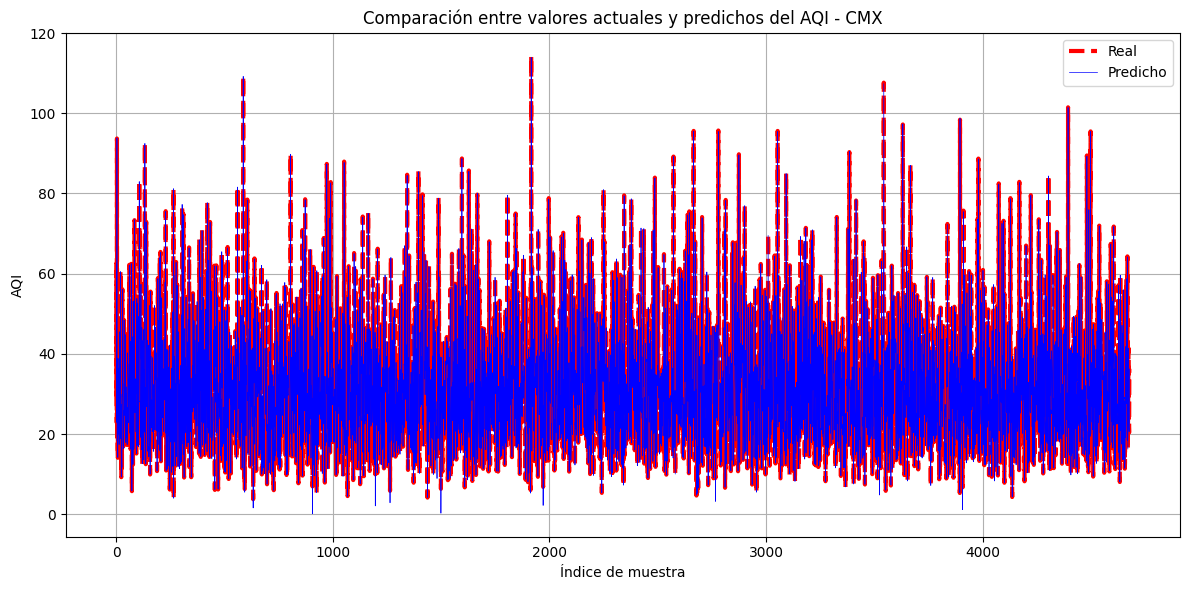

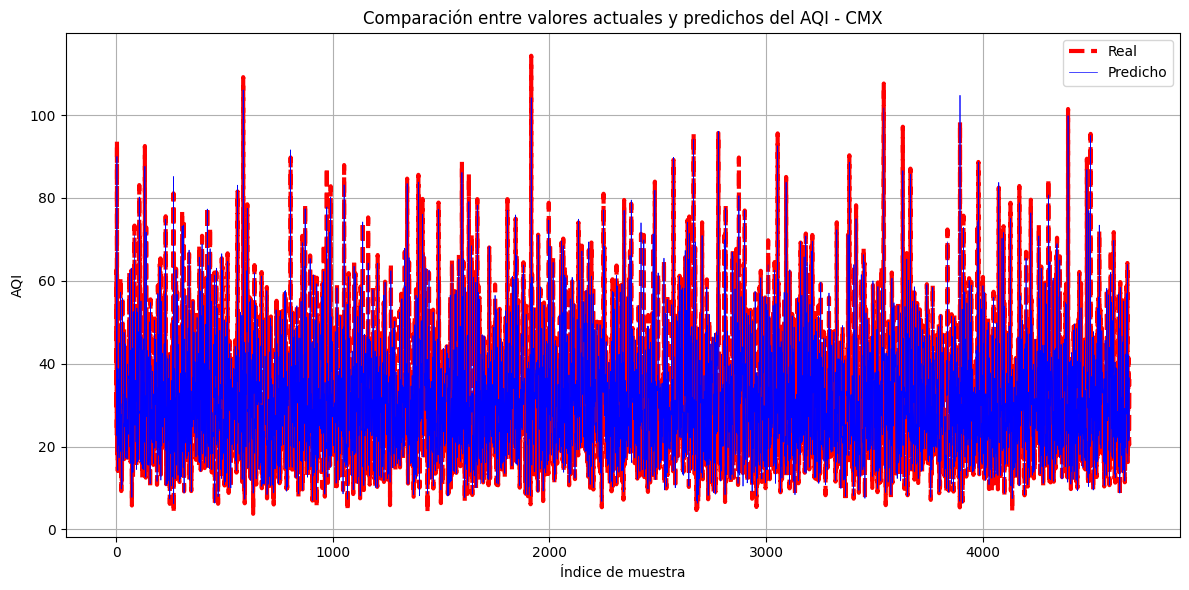

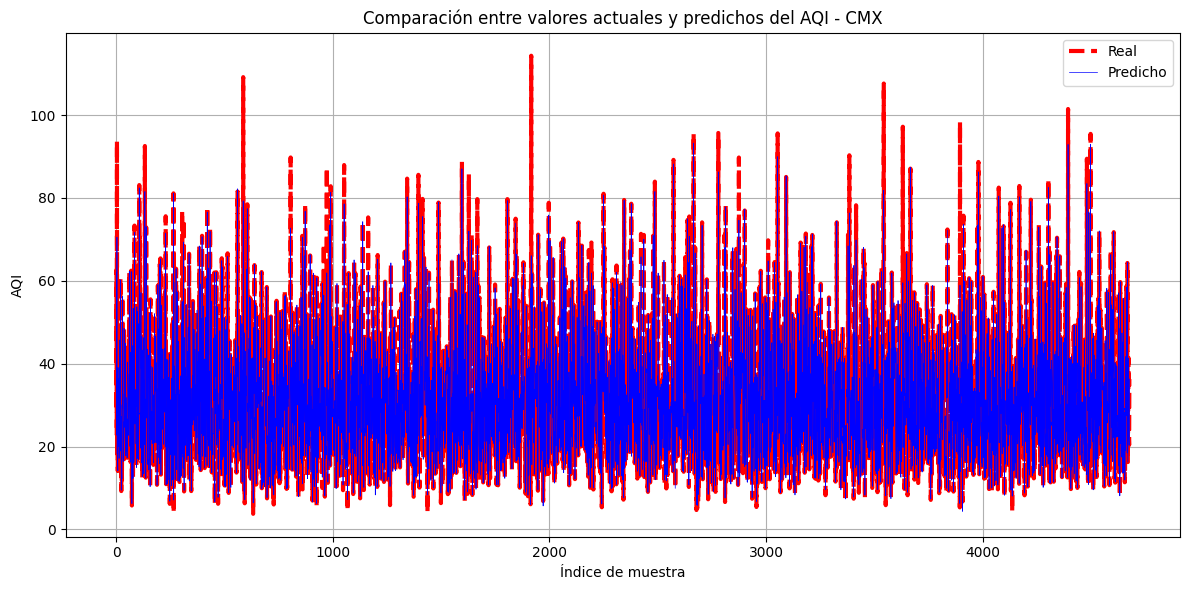

Procesando datos para la ciudad: MTY
Total de registros para MTY: 22922


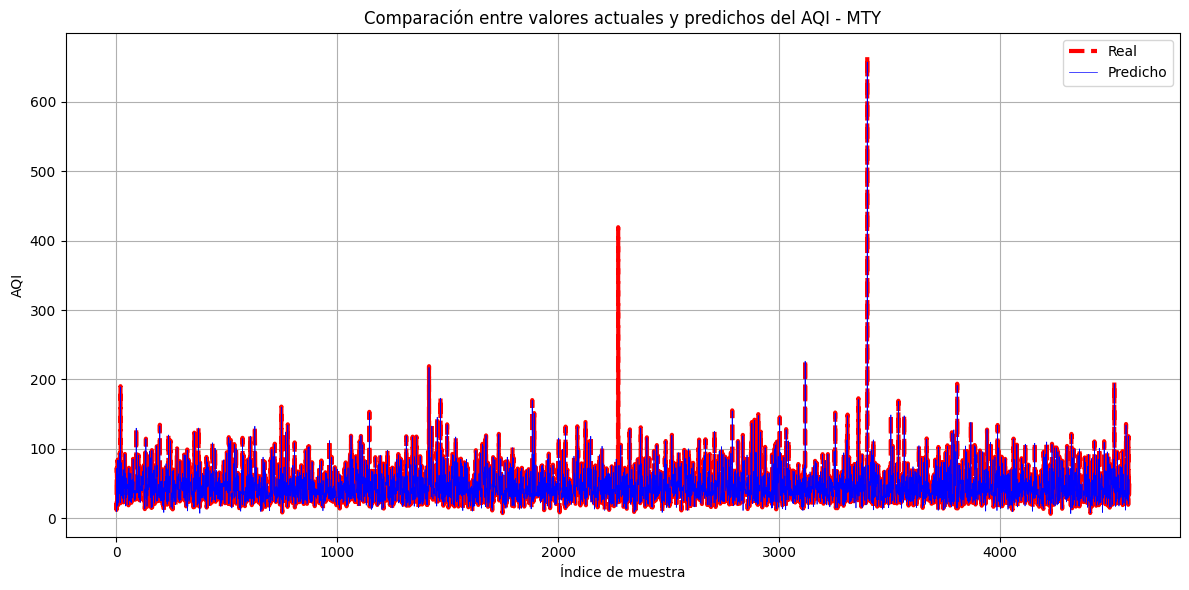

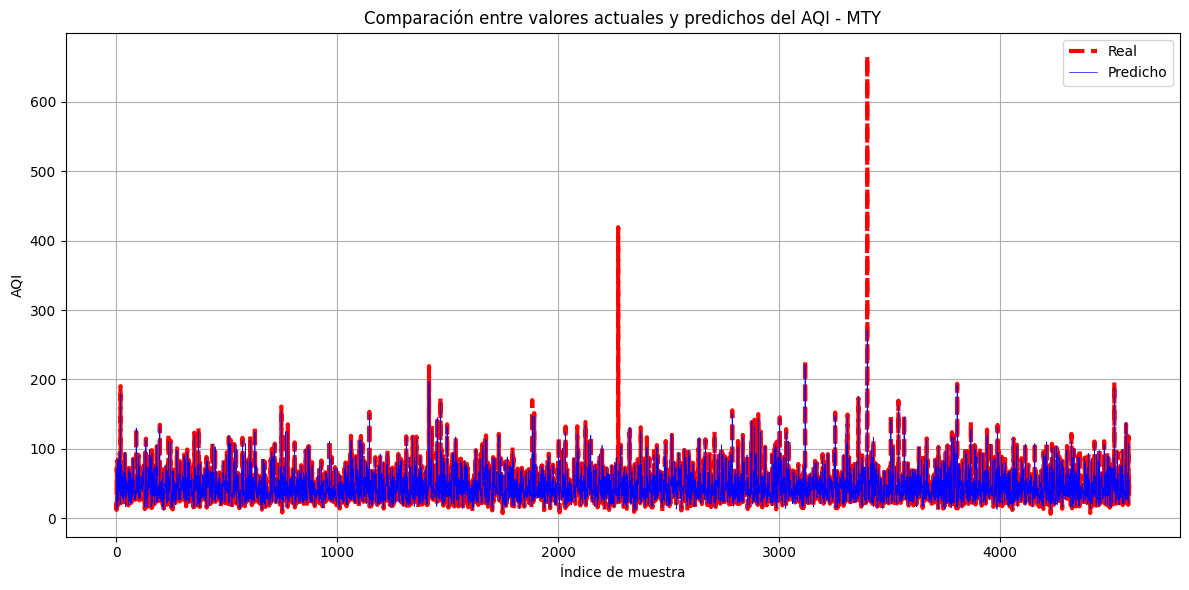

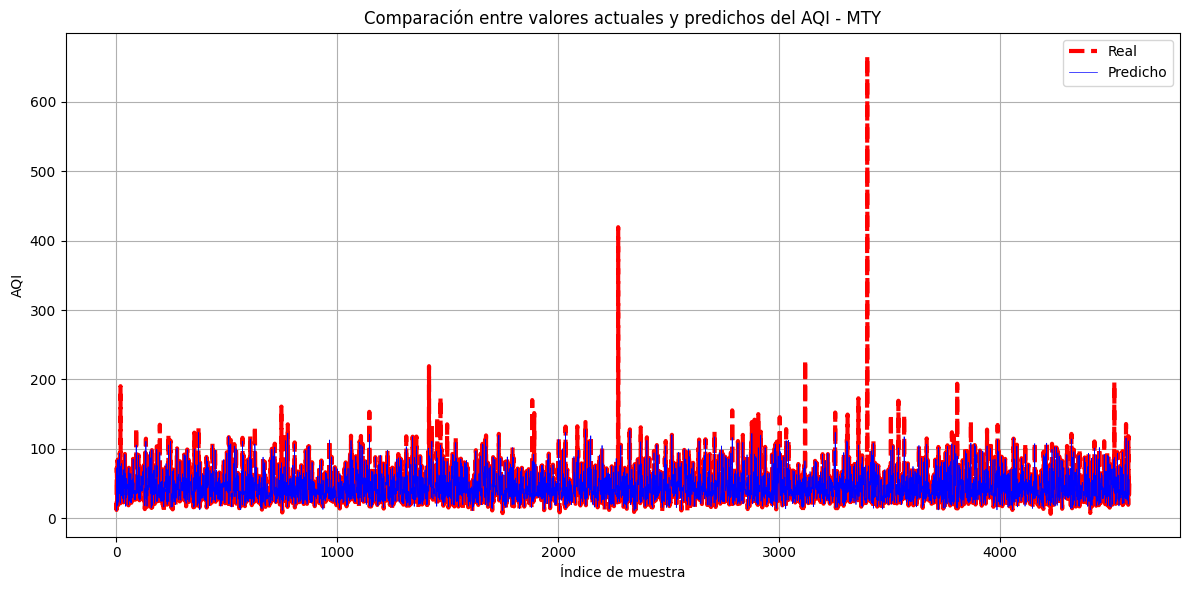

Procesando datos para la ciudad: GDL
Total de registros para GDL: 9029


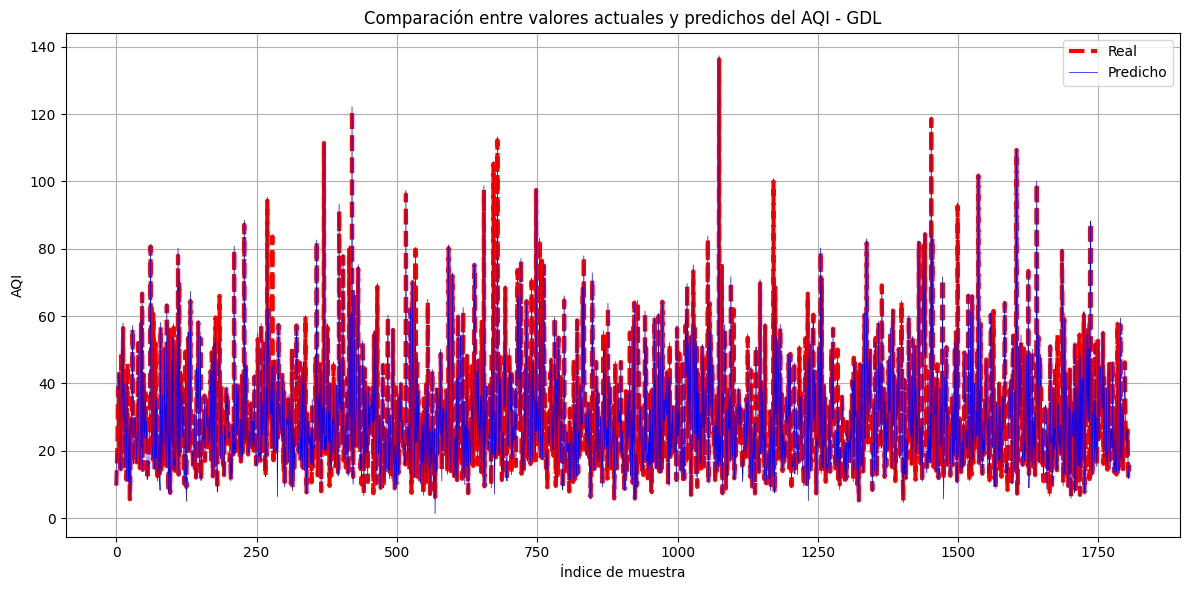

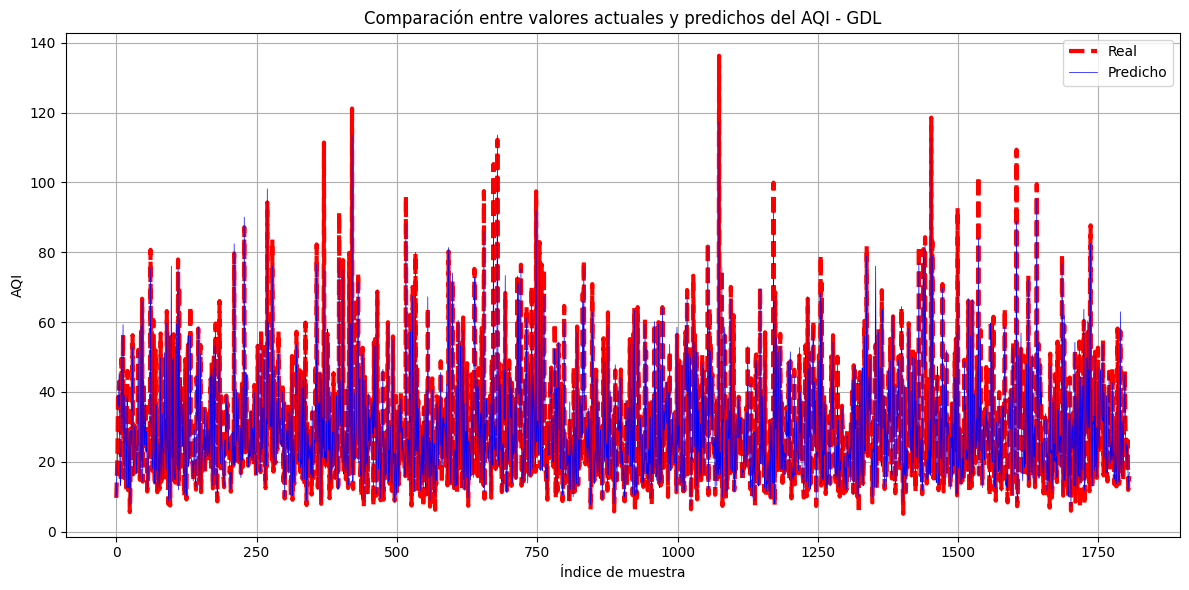

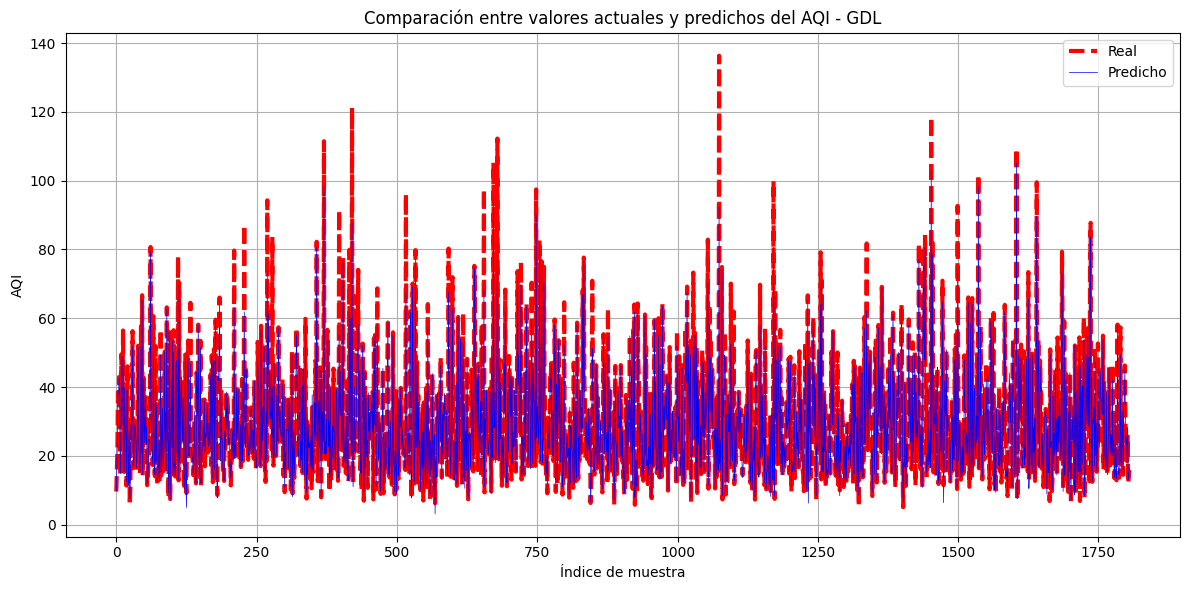

Resultados para CMX:
      Regresión Lineal       KNN       SVR
MAE           0.086326  0.729888  0.233408
RMSE          0.280629  1.117926  1.593639


Resultados para MTY:
      Regresión Lineal       KNN        SVR
MAE           0.636158  1.349209   1.033843
RMSE          5.271936  8.099163  11.828034


Resultados para GDL:
      Regresión Lineal       KNN       SVR
MAE           0.430320  1.331137  1.315547
RMSE          1.485142  2.503254  3.620097




In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Cargar el dataset
df = pd.read_csv('stations_daily_con ciudades.csv')

# Ver cuántas filas y columnas tiene el dataset antes de la limpieza
print(f"Número de filas y columnas antes de la limpieza: {df.shape}")

# Verificar los primeros registros
print(df.head())

# Paso 1: Limpieza de datos
# 1.1: Eliminamos las filas con valores nulos en las columnas de los contaminantes que vamos a analizar
df = df.dropna(subset=['PM10', 'NO2', 'O3', 'CO'])

# 1.2: Filtrar solo las ciudades que vamos a analizar: CMX, MTY, GDL
ciudades = ['CMX', 'MTY', 'GDL']
df = df[df['network_code'].isin(ciudades)]

# 1.3: Verificar que se hayan eliminado correctamente las filas con nulos
print(df.isnull().sum())

# 1.4: Imprimir cuántas filas quedan después de la limpieza
print(f"Filas restantes después de la limpieza: {df.shape[0]}")

# Paso 2: Conversión de tipos de datos
# Asegurarnos de que las concentraciones de contaminantes son numéricas
df[['PM10', 'CO2', 'O3', 'CO']] = df[['PM10', 'NO2', 'O3', 'CO']].apply(pd.to_numeric, errors='coerce')

# Paso 3: Cálculo del AQI
def calcular_aqi(pm10, no2, o3, co):
    # Usamos las fórmulas calcular el AQI basado en PM10, NO2, O3, y CO
    aqi_pm10 = (pm10 / 150) * 100
    aqi_no2 = (no2 / 200) * 100
    aqi_o3 = (o3 / 100) * 100
    aqi_co = (co / 10) * 100

    # El AQI final será el valor máximo de cada uno de los contaminantes
    return max(aqi_pm10, aqi_no2, aqi_o3, aqi_co)

# Agregar el AQI para cada ciudad
df['AQI'] = df.apply(lambda row: calcular_aqi(row['PM10'], row['NO2'], row['O3'], row['CO']), axis=1)

# Paso 4: Preprocesamiento de datos y modelo por cada ciudad
resultados = {}

# Analizamos cada ciudad por separado (CMX, MTY, GDL)
for ciudad in ciudades:
    print(f"Procesando datos para la ciudad: {ciudad}")

    # Filtrar datos de la ciudad
    df_ciudad = df[df['network_code'] == ciudad]
    print(f"Total de registros para {ciudad}: {df_ciudad.shape[0]}")

    # Variables independientes (concentraciones de contaminantes) y dependientes (AQI)
    X = df_ciudad[['PM10', 'NO2', 'O3', 'CO']]
    y = df_ciudad['AQI']

    # Normalización de las características
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # División de los datos en conjunto de entrenamiento y prueba (80% entrenamiento, 20% prueba)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Evaluación de modelos
    def evaluar_modelo(modelo, X_train, X_test, y_train, y_test):
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)

        # Calcular MAE y RMSE
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        return mae, rmse, y_pred

    # Modelos de regresión
    modelos = {
        'Regresión Lineal': LinearRegression(),
        'KNN': KNeighborsRegressor(),
        'SVR': SVR(kernel='rbf')
    }

    # Resultados para la ciudad
    resultados_ciudad = {}

    for nombre, modelo in modelos.items():
        mae, rmse, y_pred = evaluar_modelo(modelo, X_train, X_test, y_train, y_test)
        resultados_ciudad[nombre] = {'MAE': mae, 'RMSE': rmse}

        # Graficar: comparación entre reales y predichos
        y_test_sorted = y_test.reset_index(drop=True)
        y_pred_sorted = pd.Series(y_pred).reset_index(drop=True)

        # Graficar comparación para la ciudad
        plt.figure(figsize=(12, 6))
        plt.plot(y_test_sorted.values, label='Real', color='red', linestyle='--', linewidth=3, markersize=4)
        plt.plot(y_pred_sorted.values, label='Predicho', color='blue', linewidth=0.5)
        plt.title(f"Comparación entre valores actuales y predichos del AQI - {ciudad}")
        plt.xlabel("Índice de muestra")
        plt.ylabel("AQI")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Almacenar los resultados de cada ciudad
    resultados[ciudad] = resultados_ciudad

# Mostrar los resultados por ciudad
for ciudad, resultados_ciudad in resultados.items():
    print(f"Resultados para {ciudad}:")
    resultados_df = pd.DataFrame(resultados_ciudad)
    print(resultados_df)
    print("\n")
